In [17]:
import numpy
import numpy as np
from abcsysbio import abcsmc
from abcsysbio import input_output
from abcsysbio import kernels
from abcsysbio import abcModel
from abcsysbio import EpsilonSchedule
from abcsysbio import euclidian

from abcsysbio.KernelType import KernelType
from abcsysbio.PriorType import PriorType
from abcsysbio.Prior import Prior

import matplotlib
%matplotlib inline
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import re

%load_ext autoreload
%autoreload 2
matplotlib.rcParams['savefig.dpi'] = 3 * matplotlib.rcParams['savefig.dpi']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
pickling = True
plot = True
plotTimeSeries = True
debug = 1#or 0 or 2 (higher the more details)
randomSeed = None #or an integer
timing = False
fname = "results_"  # outfolder
custom_kernel = False
restart = False
mode = 0

if randomSeed is not None:
    print "#### Seeding random number generator : ", randomSeed
    numpy.random.seed(randomSeed)

modelKernel = 0.7
nparticles = 200

kernel = KernelType.component_wise_uniform  #check out kernalType.py

nbatch = 10

# Defining models and Performing Inference

This is based on the toy example given in the EasyABC manual. 

In [19]:
# Define Priors
prior_x1 = Prior(type=PriorType.uniform, lower_bound=0, upper_bound=1)
prior_x2 = Prior(type=PriorType.normal, mean=0, variance=2)


# Define the model
def simulation(paramsArray):
    
    r = np.empty((len(paramsArray), 1, 1, 2))
    for i, x in enumerate(paramsArray):
        r[i, 0, 0, 0] = x[0] + x[1] + np.random.randn() * np.sqrt(0.1)
        r[i, 0, 0, 1] = x[0] * x[1] * np.random.randn() * np.sqrt(0.1)

    return r

model = abcModel.AbcModel(name='toy',
                           simulationFn=simulation,
                           distanceFn=euclidian.euclidian_distance,
                           nparameters=2,
                           prior=[prior_x1, prior_x2])
models = [model]

names  = [x.name for x in models]
nmodels = len(models)
modelprior = [1 / float(nmodels)] * nmodels

# set the required kernel functions
kernelfn = kernels.get_kernel
kernelpdffn = kernels.get_parameter_kernel_pdf
perturbfn = kernels.perturb_particle


In [20]:
class Data:
    def __init__(self, times, values):
        self.timepoints = times
        self.values = values

In [21]:
# Can sample a random set of parameters, and then use these for a single simulation
true_x = [np.random.rand(), np.sqrt(2)*np.random.randn()]
y = simulation([true_x])[0,0,:,:]
print true_x, y


[0.16510972643280797, -1.1737185452435477] [[-0.69734731  0.00390322]]


In [25]:
# Or use these hard-coded values
true_x = [0.8578191333748426, 0.84483674978656687]
y = [[ 1.54395668, -0.13665554]]

In [26]:
# remove existing results
!rm -r results_

In [27]:
restart = False
fname = 'results_'

niter = 10
firstEpsilon = 5
lastEpsilon  = 0.3 #rstEpsilon * 0.01
tol_type = 'exp'
epsilonSchedule = EpsilonSchedule.EpsilonSchedule(tol_type, lastEpsilon, firstEpsilon, niter).tol
epsilonSchedule

io = input_output.InputOutput(fname, restart, False, False)
io.create_output_folders(["toy"], pickling, True, False)

abcSmcInstance = abcsmc.Abcsmc(models=models,
                               nparticles=nparticles,
                               modelprior=modelprior,
                               #data=Data([0], [[1.5, 2]]),
                               data=Data([0], y),
                               
                               beta=1,
                               nbatch=nbatch,
                               model_kernel=modelKernel,
                               debug=debug,
                               timing=timing,
                               distancefn=euclidian.euclidian_distance,
                               kernel_type=kernel,
                               kernelfn=kernelfn,
                               kernelpdffn=kernelpdffn,
                               perturbfn=perturbfn)

allResults = abcSmcInstance.run_fixed_schedule(epsilonSchedule, io, store_all_results=True)

### iteration:1, eps=5.00, sampled=201, accepted=99.5%
	 model marginals                  : [1.0000000000000007]
### iteration:2, eps=3.66, sampled=256, accepted=78.1%
	 model marginals                  : [1.0000000000000004]
### iteration:3, eps=2.68, sampled=349, accepted=57.3%
	 model marginals                  : [0.99999999999999978]
### iteration:4, eps=1.96, sampled=361, accepted=55.4%
	 model marginals                  : [0.99999999999999967]
### iteration:5, eps=1.43, sampled=378, accepted=52.9%
	 model marginals                  : [1.0000000000000002]
### iteration:6, eps=1.05, sampled=437, accepted=45.8%
	 model marginals                  : [1.0]
### iteration:7, eps=0.77, sampled=435, accepted=46.0%
	 model marginals                  : [1.0]
### iteration:8, eps=0.56, sampled=558, accepted=35.8%
	 model marginals                  : [0.99999999999999989]
### iteration:9, eps=0.41, sampled=631, accepted=31.7%
	 model marginals                  : [0.99999999999999944]
### itera

# Plotting

In [28]:
from abcsysbio import plotter

Let's plot the estimated posterior in the last population, to get an idea of how much uncertainty we have about the parameters:


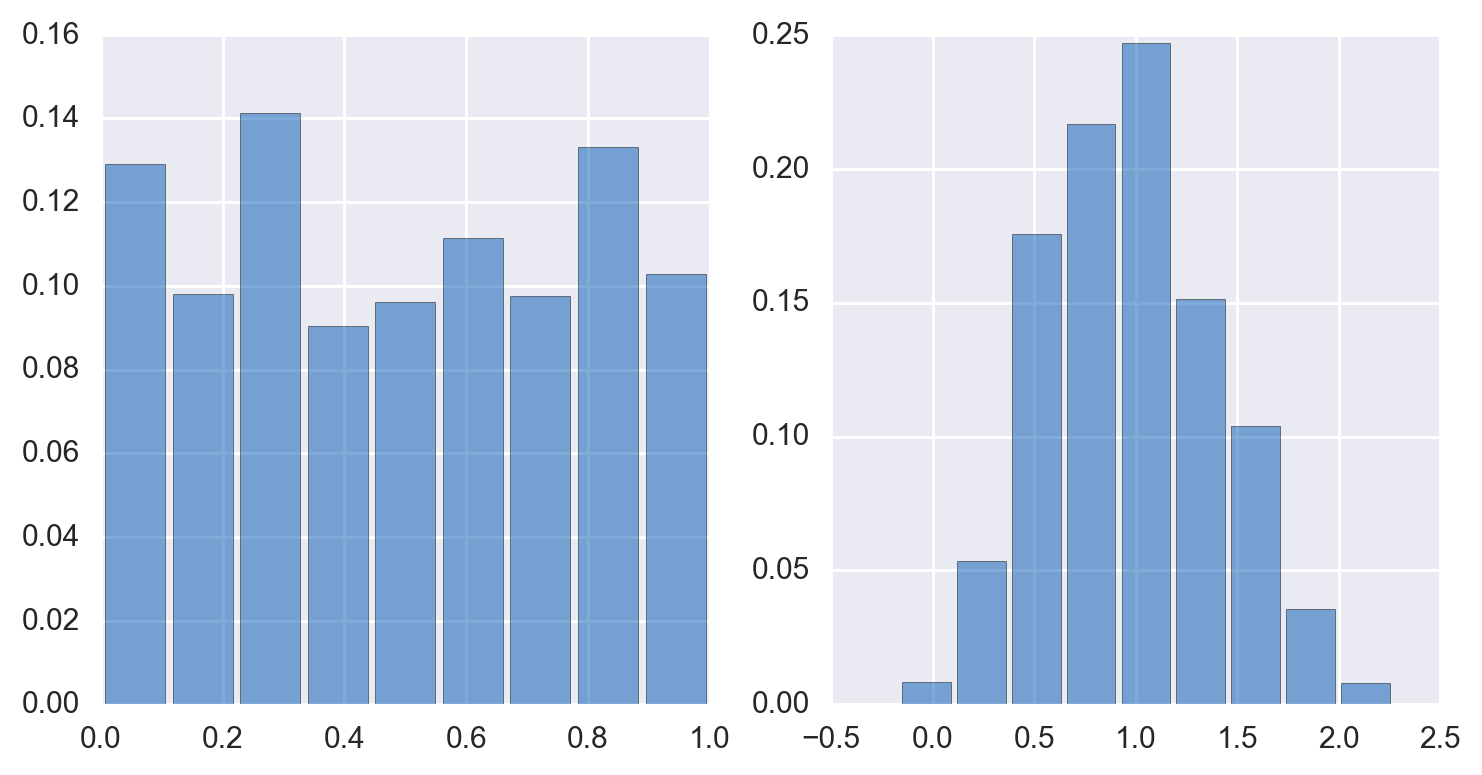

In [29]:
plotter.plotHistogram(allResults[-1], 0, models=models)

Let's examine this more closely with a pairplot for all iterations, indicating the true parameter values with a cross-hair.

This shows how our uncertainty is decreaisng with successive iterations.
The point-cloud isn't *centered* on the true value, but does cover it.

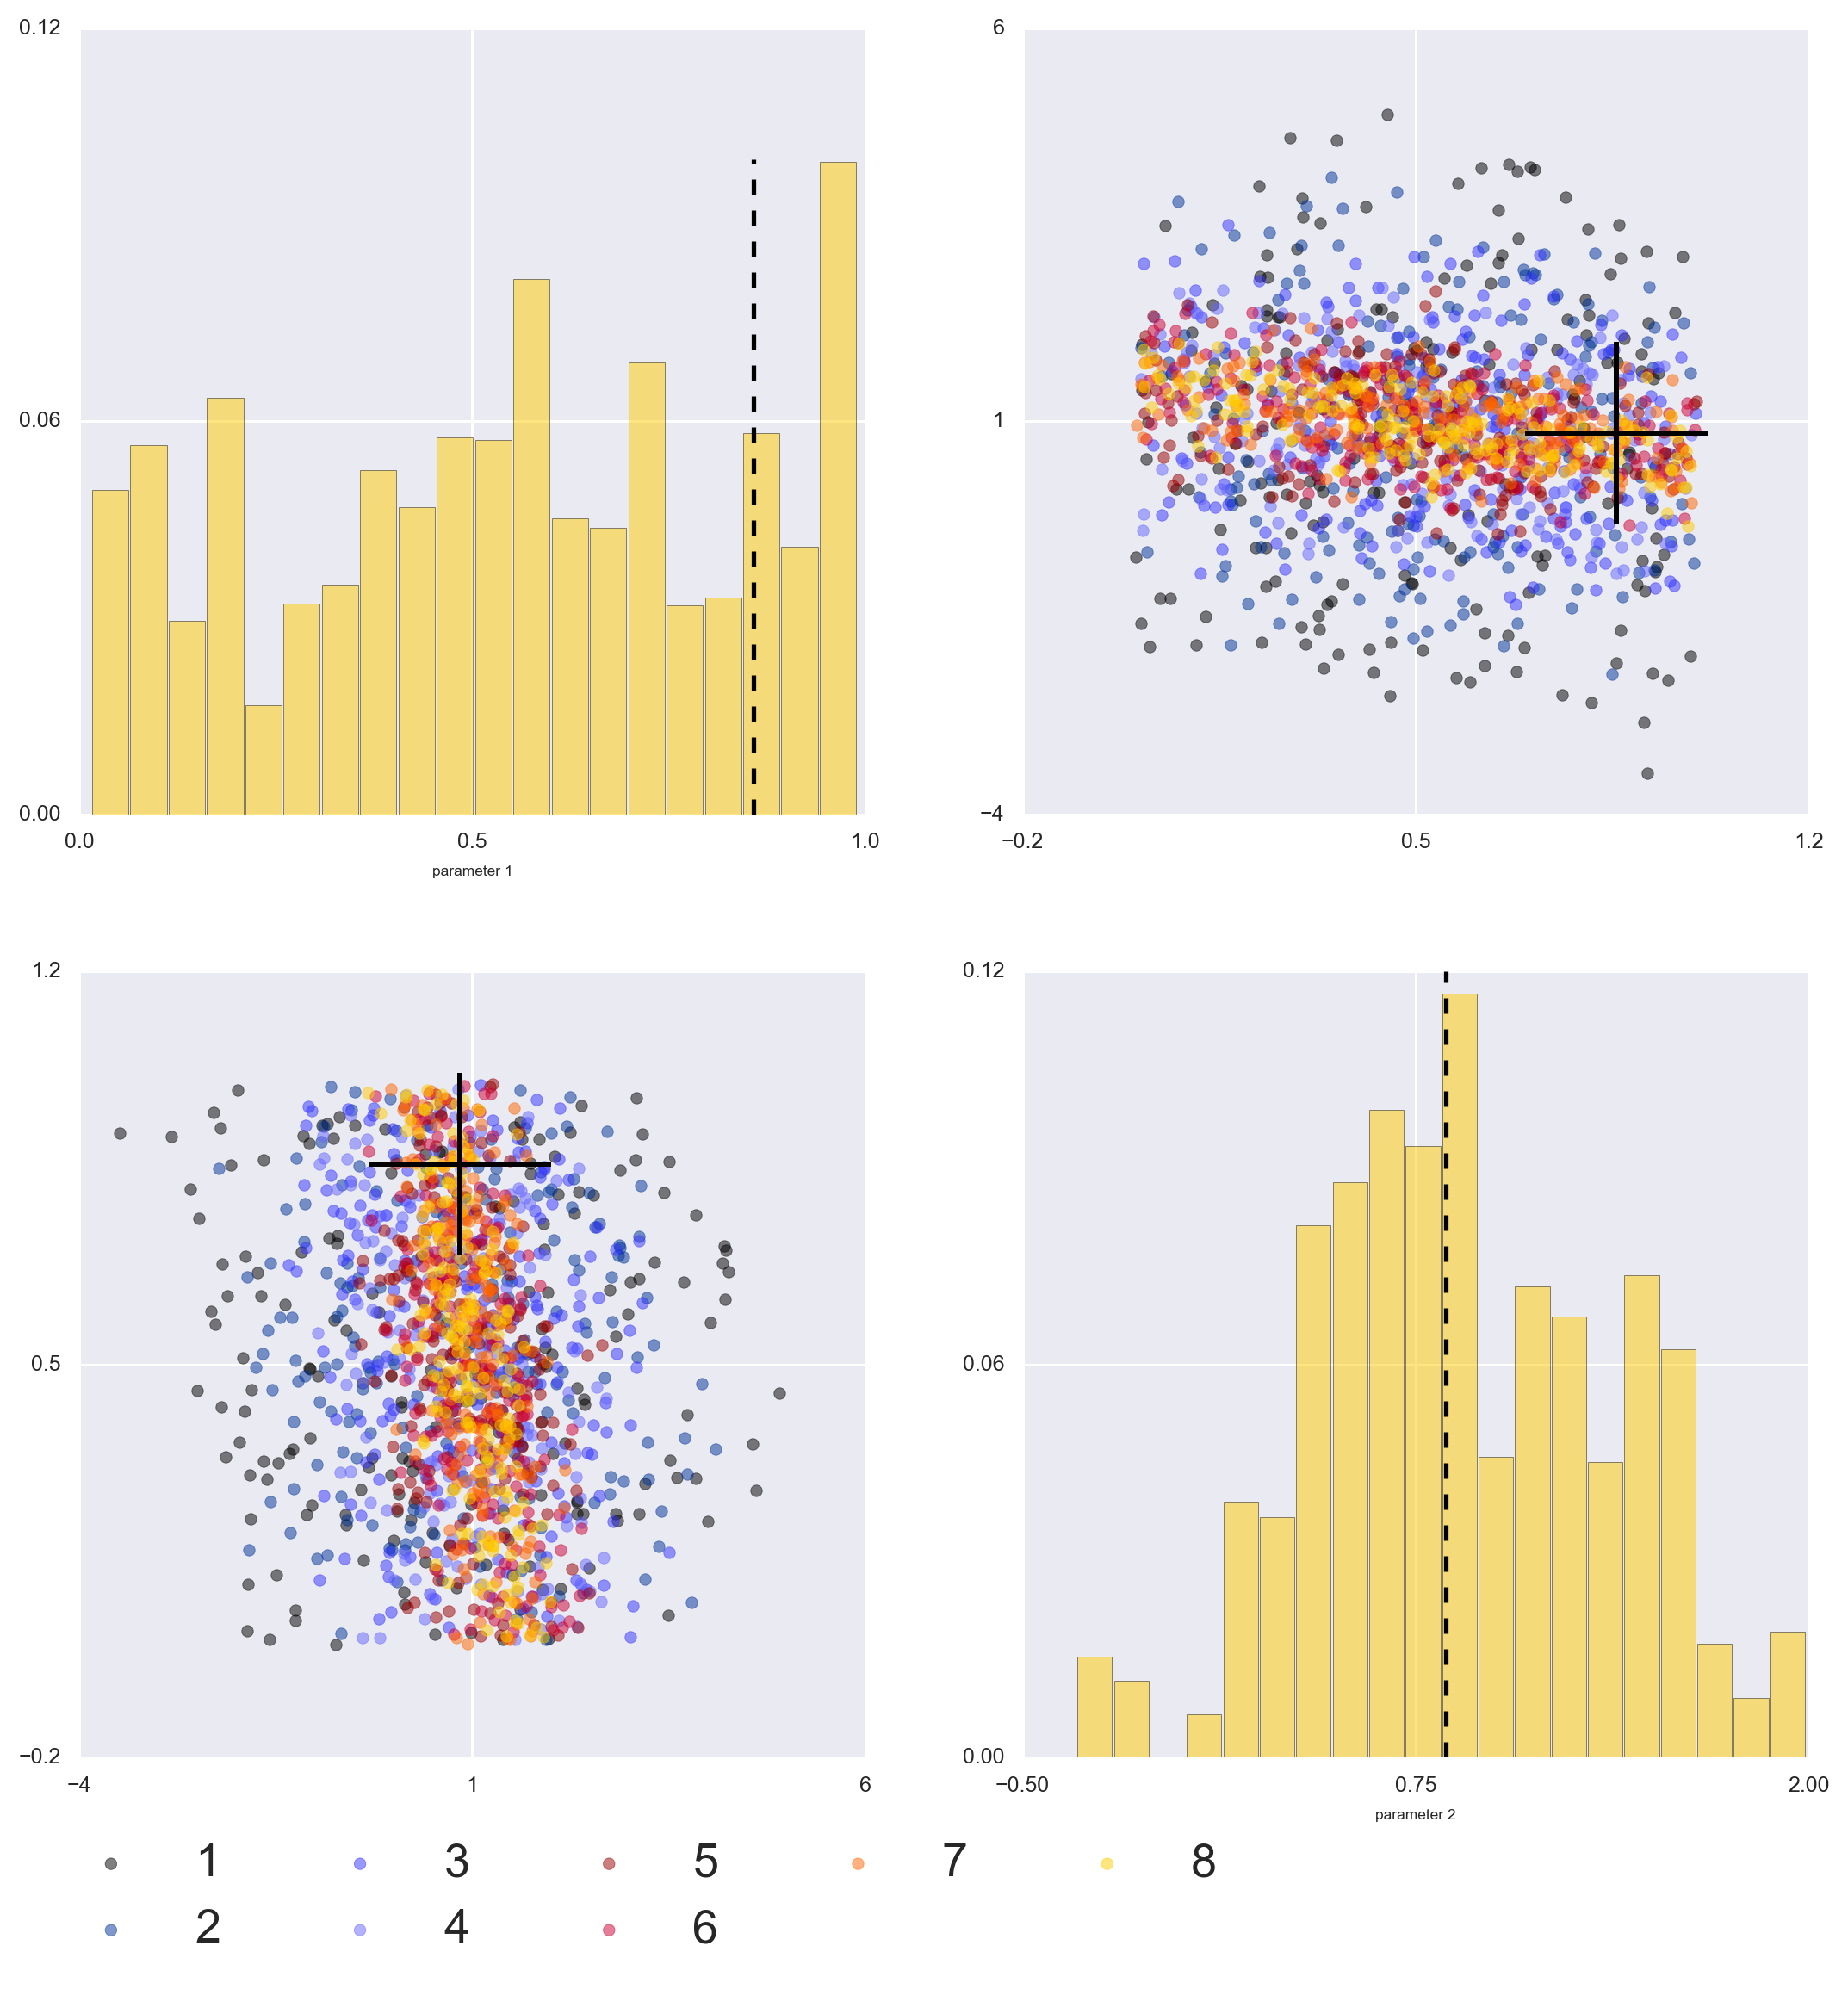

In [30]:
plotter.doPairPlot(allResults, 0, range(1,niter-1), models,actualValues=true_x)

The plot is a little confusing, because it superimposes the data for each iteration. Let's take a look at just the results after the first iteration:

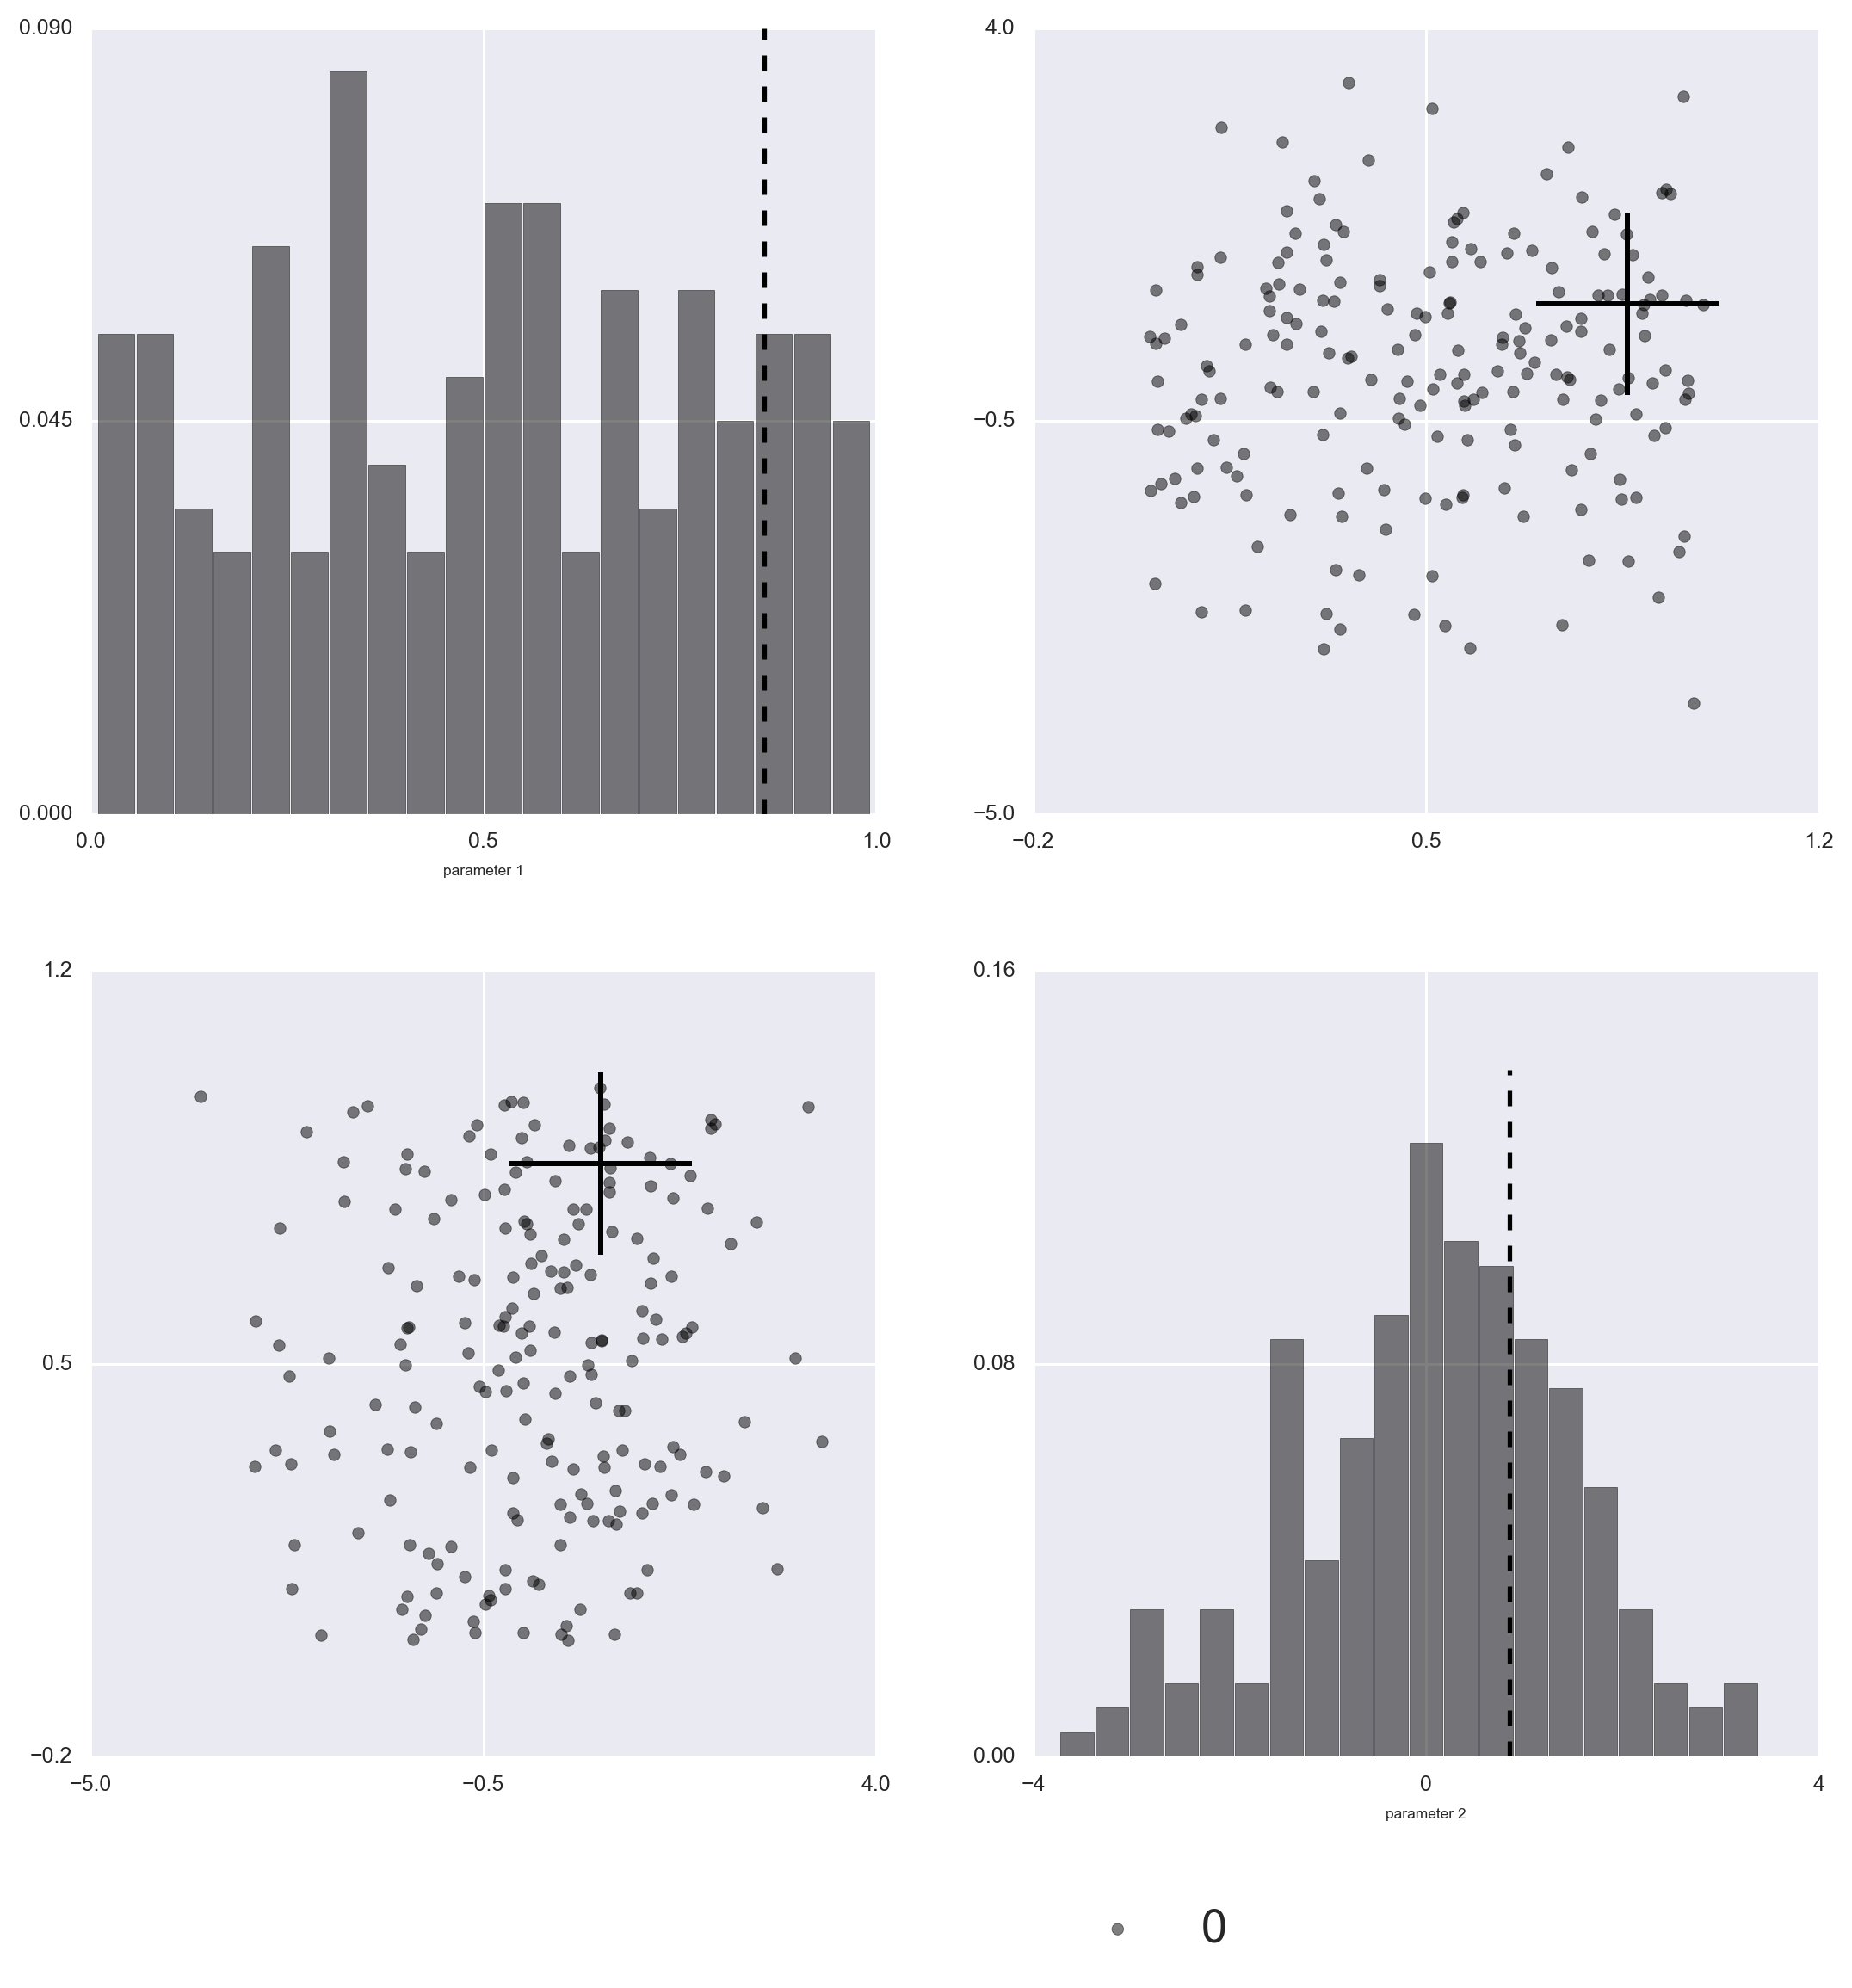

In [31]:
plotter.doPairPlot(allResults, 0, [0], models,actualValues=true_x)

Comparing this to the estimate from the final iteration, we can see that our uncertainty about $x_2$ has fallen a lot by the final iteration, but we're still very unsure about the value of $x_2$:

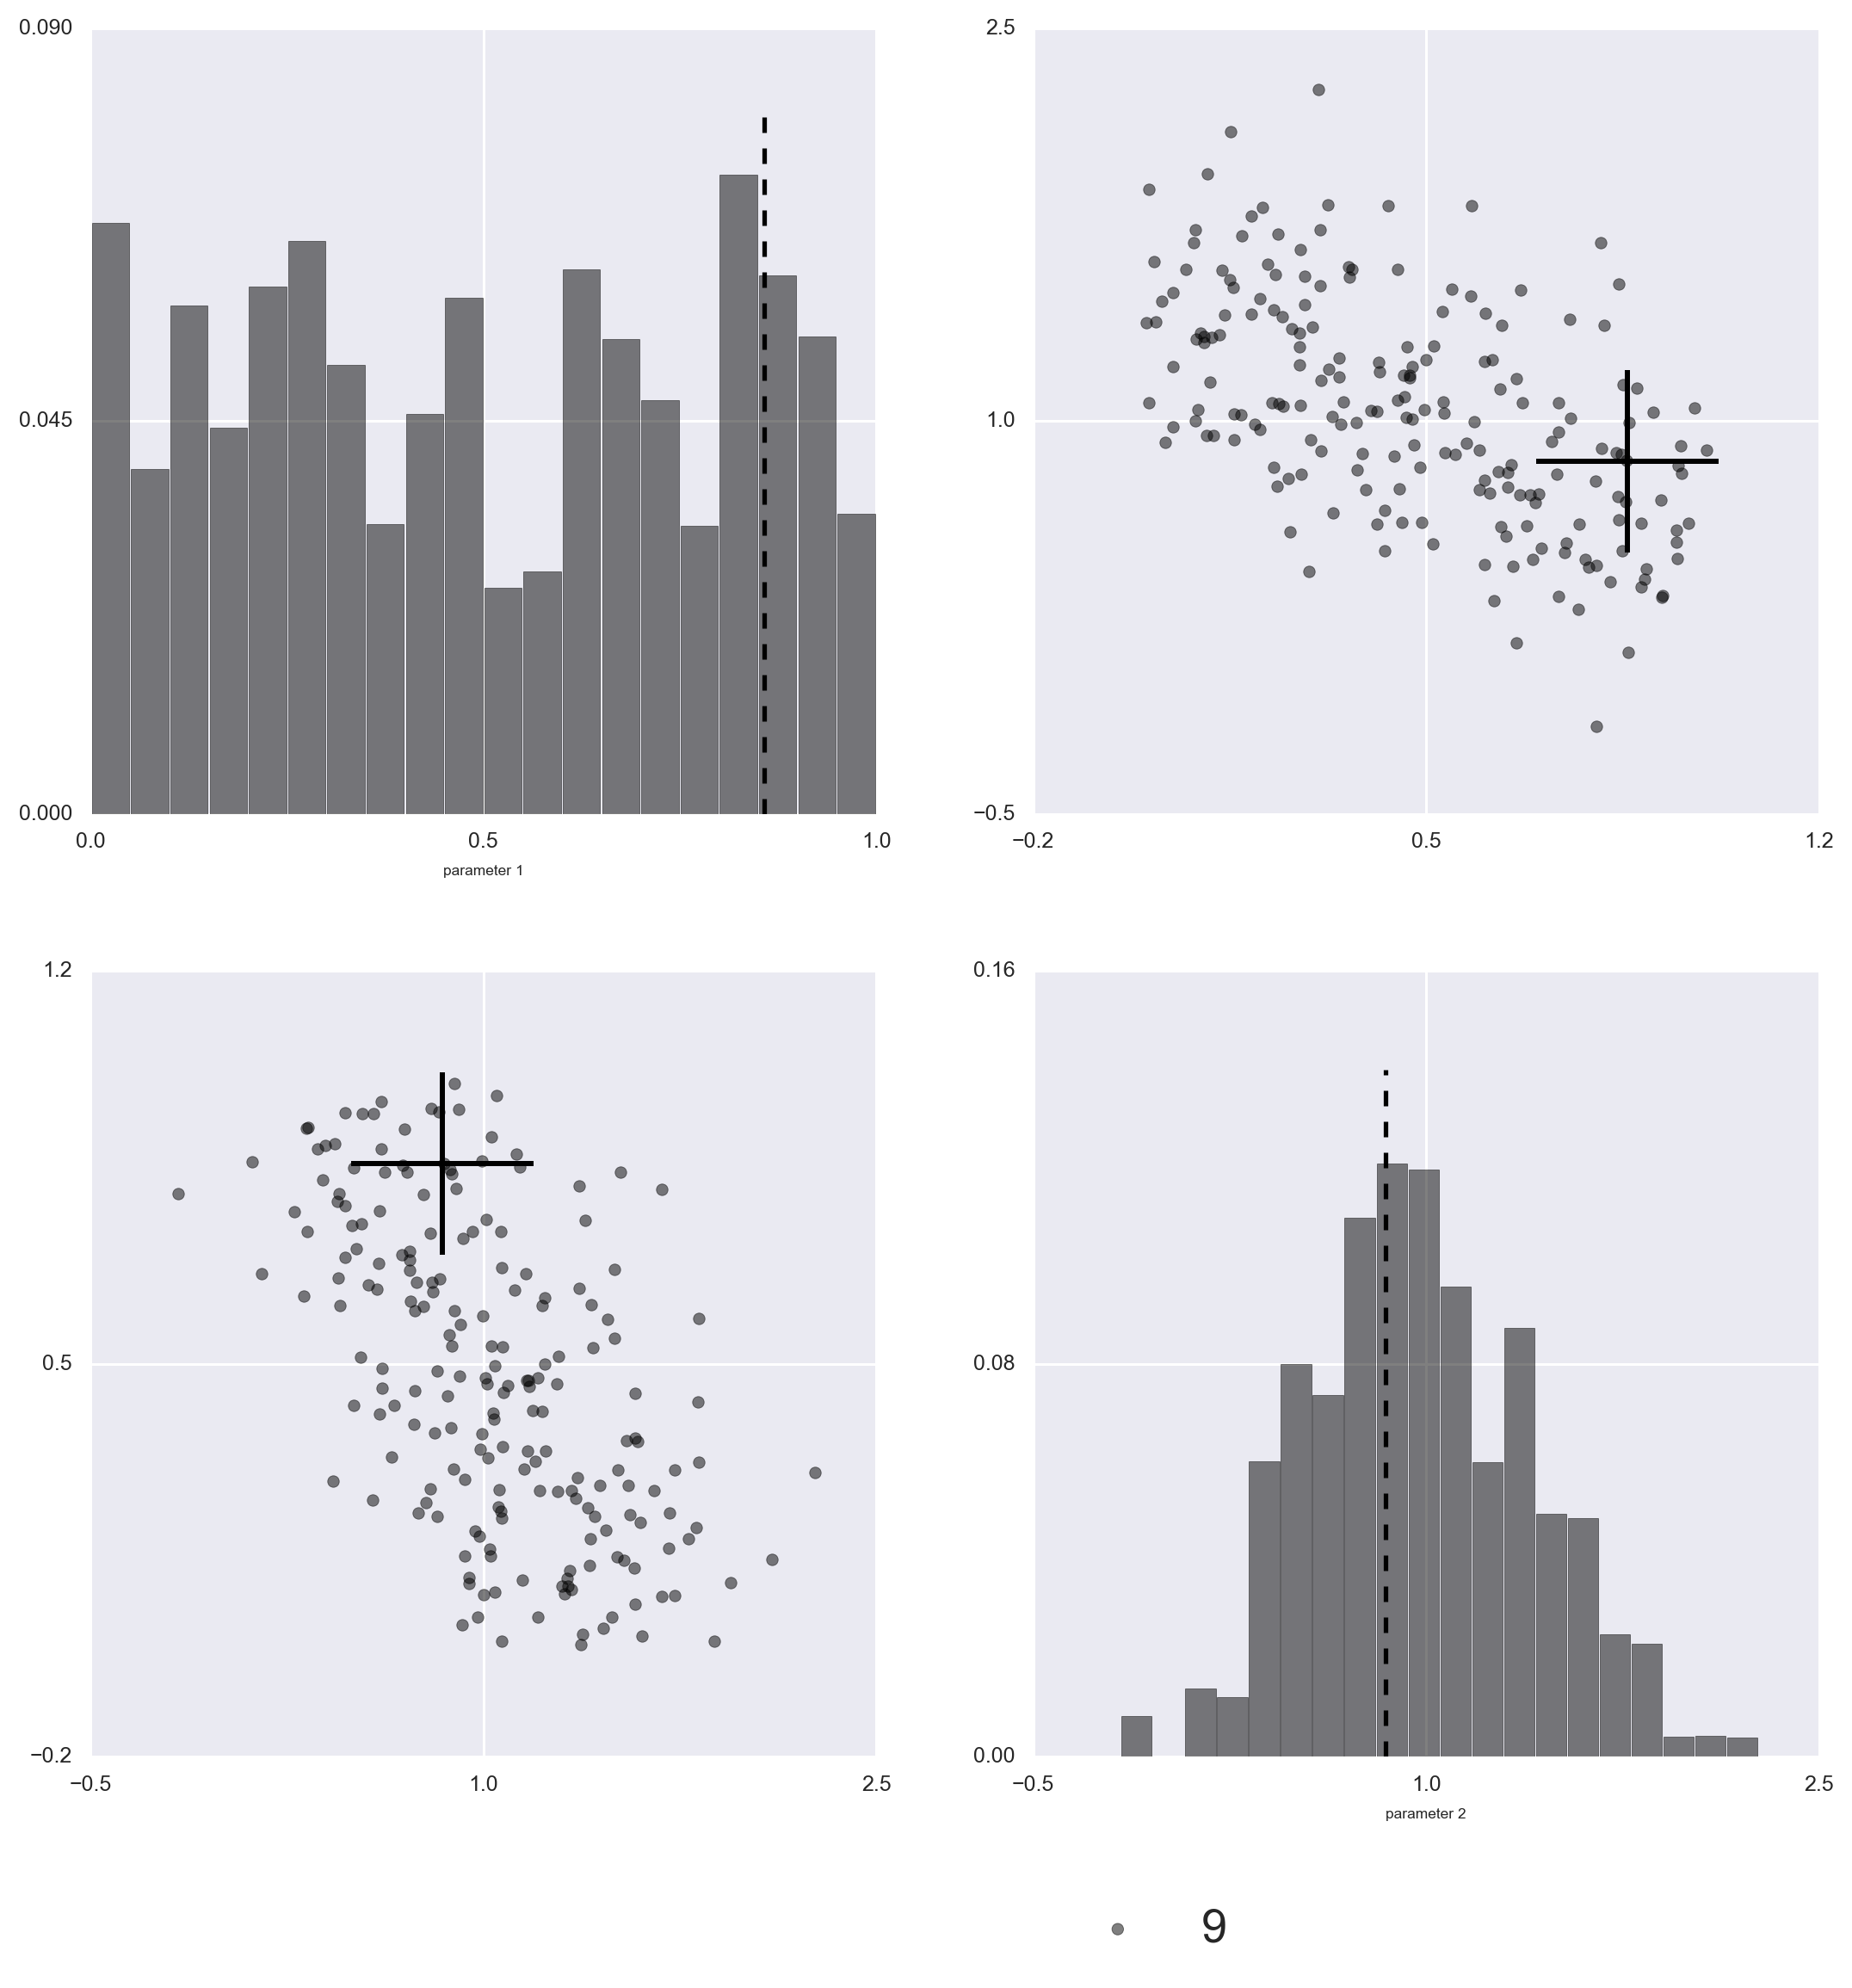

In [32]:
plotter.doPairPlot(allResults, 0, [niter-1], models,actualValues=true_x)